# Imports and Reading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures

In [2]:
import httpimport
url = 'https://raw.githubusercontent.com/zach-brown-18/class-toolkit/main/eda/'
with httpimport.remote_repo('columns', url):
    import columns

### Functions

In [3]:
def strip_white(df):
    '''Strip leading whitespace for all string columns'''
    string_columns = columns.get_str_column_names(df)
    for col in string_columns:
        df[col] = df[col].map(str.strip)

In [4]:
def replace_missing(df):
    df['workclass'].replace('?', df['workclass'].mode()[0], inplace=True)
    df['occupation'].replace('?', df['occupation'].mode()[0], inplace=True)
    df['native-country'].replace('?', df['native-country'].mode()[0], inplace=True)

In [5]:
def add_dummy(df):
    string_columns = columns.get_str_column_names(df)
    dummies = pd.get_dummies(df[string_columns], drop_first=True)
    df = pd.concat([df.select_dtypes([np.number]),dummies],axis=1)
    return df

In [6]:
def add_poly(df, test=False):
    poly = PolynomialFeatures(3, include_bias=False)
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    if test:
        poly_features = df.select_dtypes(include=numerics).columns
    else:
        poly_features = df.select_dtypes(include=numerics).drop(columns='wage').columns

    polys = poly.fit_transform(df[poly_features])

    # Drop single order poly features
    df_poly = pd.DataFrame(polys, columns=poly.get_feature_names(poly_features)).drop(columns=poly_features)

    # Everything we need
    df_final = pd.concat([df, df_poly], axis=1)
    
    return df_final

# Data Cleaning

In [8]:
df = pd.read_csv('./data/large_train_sample.csv')
test = pd.read_csv('./data/test_data.csv')

In [9]:
print(df.shape)
print(test.shape)

(32561, 14)
(16281, 13)


In [10]:
# Peek the test data
test.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,Male,0,0,40,United-States


In [11]:
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,<=50K


In [12]:
# making wage a binary column. 1 if wage is above 50k and 0 if wage is below 50
df['wage'] = df['wage'].map({' <=50K': 0 , ' >50K': 1})

In [13]:
strip_white(df)
strip_white(test)

# Imputing values

In [14]:
replace_missing(df)
replace_missing(test)

In [15]:
print(df.shape)
print(test.shape)

(32561, 14)
(16281, 13)


# Check for outliers

In [16]:
df['capital-gain'].describe()

count    32561.000000
mean      1077.648844
std       7385.292085
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64

In [17]:
df['capital-gain'].value_counts()

0        29849
15024      347
7688       284
7298       246
99999      159
         ...  
4931         1
1455         1
6097         1
22040        1
1111         1
Name: capital-gain, Length: 119, dtype: int64

In [18]:
# capital-gain = 99999 means the person is really rich
df[df['capital-gain'] == 99999]['wage'].value_counts()

1    159
Name: wage, dtype: int64

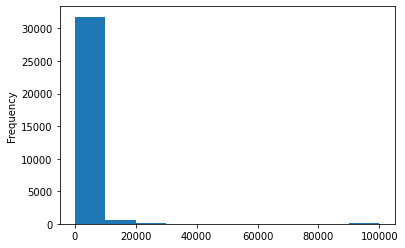

In [19]:
df['capital-gain'].plot(kind='hist');

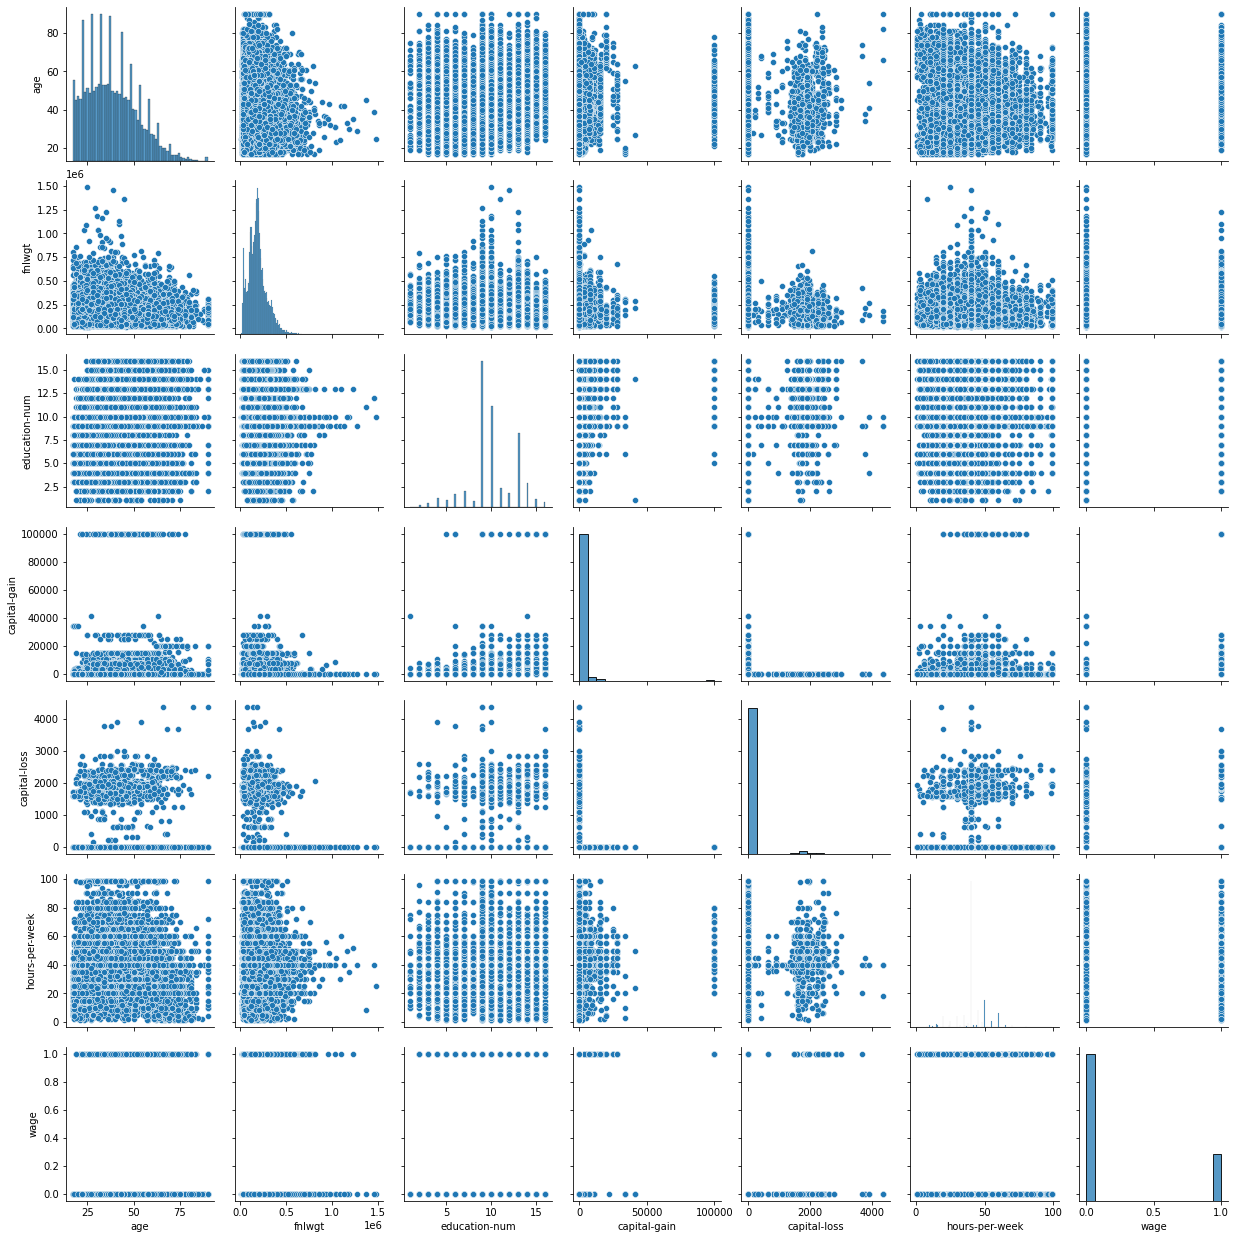

In [20]:
sns.pairplot(df);

# Polynomial feature engineering

In [21]:
# Train
df = add_dummy(df)
df_final = add_poly(df)

# Test
test = add_dummy(test)
test_final = add_poly(test, test=True)

In [22]:
# Final dataframe
top_correlated = abs(df_final.corr()['wage']).sort_values(ascending=False).head(43).index
df_final = df_final[top_correlated]

In [23]:
# help from https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on

# Create correlation matrix
corr_matrix = df_final.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df_final.drop(to_drop, axis=1, inplace=True)

In [24]:
# Finalize test data with same 20 features as training data
final_features = df_final.drop(columns='wage').columns
test_final = test_final[final_features]

In [26]:
# Save cleaned, feature engineered dataset
df_final.to_csv('./data/large_clean.csv', index=False)
test_final.to_csv('./data/new_data_clean.csv', index=False)